## Is it a black widow spider?

In [49]:
!pip install -Uqq fastai

In [50]:
#NB: Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.
#    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [51]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai 'duckduckgo_search>=6.2'  # DuckDuckGo Image Search API

In 2015 the idea of creating a computer system that could recognise birds was considered so outrageously challenging that it was the basis of [this XKCD joke](https://xkcd.com/1425/):

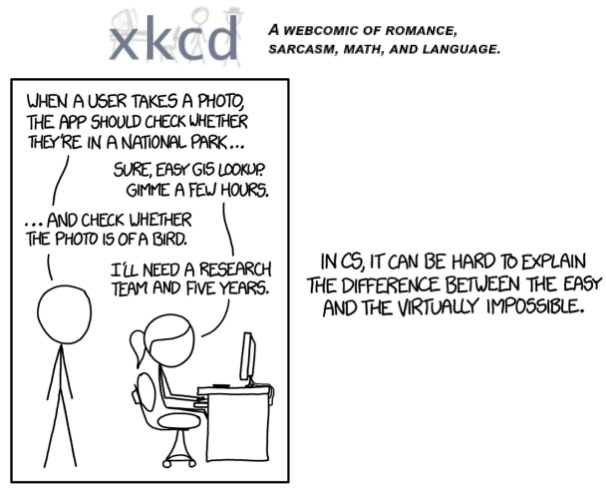

But today, we can do exactly that, in just a few minutes, using entirely free resources!

The basic steps we'll take are:

1. Use DuckDuckGo to search for images of "bird photos"
1. Use DuckDuckGo to search for images of "forest photos"
1. Fine-tune a pretrained neural network to recognise these two groups
1. Try running this model on a picture of a bird and see if it works.

## Step 1: Download images of Black Widow spiders and a general population of spiders. 

In [52]:
from duckduckgo_search import DDGS  # Import DuckDuckGo search

def search_duckduckgo_images(keywords, max_images=10):
    """Search for images using DuckDuckGo and return valid image URLs."""
    results = list(DDGS().images(keywords, max_results=max_images))

    # Extract only valid image URLs
    images = [img["image"] for img in results]
    return [url for url in images if url.endswith((".jpg", ".png", ".jpeg"))]

Let's start by searching for a photo of black widow spiders and seeing what kind of result we get. We'll start by getting URLs from a search:

In [53]:
# Fetch filtered URLs
urls = search_duckduckgo_images("black widow spider photos", max_images=1)
print(urls)  # Check the URLs before downloading

['https://cdn.mos.cms.futurecdn.net/rmeU336jj82TWSrRTAURnj-1200-80.jpg']


...and then download a URL and take a look at it:

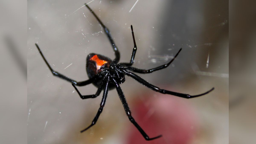

In [54]:
from fastdownload import download_url
dest = 'bwspider.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Now we will do the same for "spiders" in general

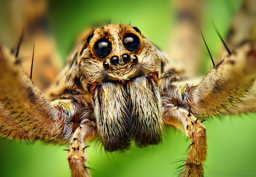

In [55]:
download_url(search_duckduckgo_images('spider photos', max_images=1)[0], 'spider.jpg', show_progress=False)
Image.open('spider.jpg').to_thumb(256,256)

Our searches seem to be giving reasonable results, so let's grab a few examples of each of "black widow spiders" and "spider" photos, and save each group of photos to a different folder:

In [56]:
import time
from pathlib import Path
from fastai.vision.all import *
from duckduckgo_search import DDGS  # Ensure DuckDuckGo search is installed

# Define dataset path
path = Path('blackwidow_or_not')
searches = ['black widow spider', 'spider']

def fetch_images(search_term, folder, max_images=50):
    """Fetch images from DuckDuckGo and store them in the given folder."""
    dest = path/folder
    dest.mkdir(exist_ok=True, parents=True)

    print(f"🔄 Searching images for: {search_term} ...")
    urls = search_duckduckgo_images(f'{search_term} photo', max_images=max_images)

    # Check if valid images are found
    if not urls:
        print(f"⚠️ No images found for {search_term}")
        return

    print(f"📥 Downloading {len(urls)} images to {dest} ...")
    download_images(dest, urls=urls)

    # Introduce a delay to avoid being blocked
    time.sleep(5)

    print(f"🔍 Verifying and cleaning corrupted images in {dest} ...")
    failed = verify_images(get_image_files(dest))
    failed.map(Path.unlink)  # Remove failed images

    print(f"✅ Resizing images for {search_term} ...")
    resize_images(dest, max_size=400)

for search, category in zip(searches, ["black_widow", "other_spiders"]):
    fetch_images(search, category)

print("🎉 Image collection complete!")

🔄 Searching images for: black widow spider ...
📥 Downloading 46 images to blackwidow_or_not/black_widow ...
🔍 Verifying and cleaning corrupted images in blackwidow_or_not/black_widow ...
✅ Resizing images for black widow spider ...
🔄 Searching images for: spider ...
📥 Downloading 43 images to blackwidow_or_not/other_spiders ...
🔍 Verifying and cleaning corrupted images in blackwidow_or_not/other_spiders ...
✅ Resizing images for spider ...
🎉 Image collection complete!


## Step 2: Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [57]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

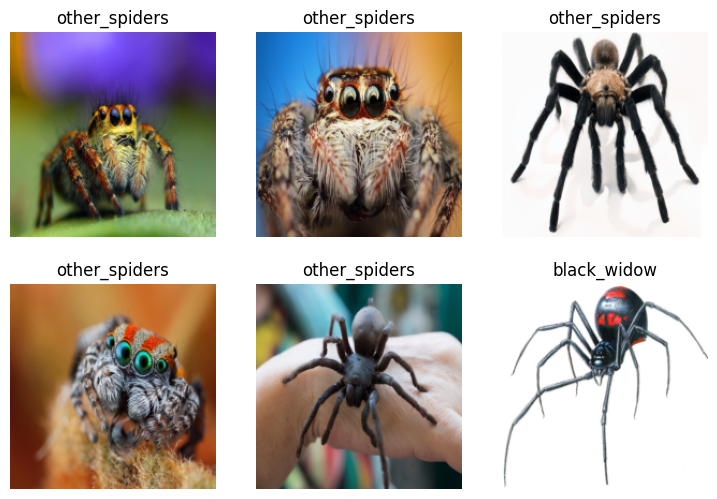

In [58]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

Here's what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "black widow spider" or "spider").

    get_items=get_image_files, 

To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *black widow spider* or *spider*).

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [59]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,0.811959,0.071447,0.000000,00:09


epoch,train_loss,valid_loss,error_rate,time
0,0.160935,0.017608,0.000000,00:08
1,0.115828,0.000626,0.000000,00:07
2,0.098120,0.006970,0.000000,00:08


Generally when I run this I see greater than 99% accuracy on the validation set (although it might vary a bit from run to run).

"Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the *pretrained model*), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in *imagenet*, and widely-used computer vision dataset with images covering 1000 categories) For details on fine-tuning and why it's important, check out the [free fast.ai course](https://course.fast.ai/).

## Step 3: Use model

[](http://)Use the model to see how well it identifies a black widow spider from a population of spiders in general

In [60]:
is_bwspider,_,probs = learn.predict(PILImage.create('bwspider.jpg'))
print(f"This is a: {is_bwspider}.")
print(f"Probability it's a black widow: {probs[0]:.4f}")

This is a: black_widow.
Probability it's a black widow: 1.0000


# *If you need to reset you image folder structure

In [45]:
import shutil
from pathlib import Path

# Define dataset path
dataset_path = Path('blackwidow_or_not')

# Define correct categories
valid_categories = {"black_widow", "other_spiders"}

# Delete unwanted folders
for folder in dataset_path.iterdir():
    if folder.is_dir() and folder.name not in valid_categories:
        shutil.rmtree(folder)
        print(f"❌ Deleted invalid folder: {folder.name}")

# Confirm final structure
print("\n✅ Remaining folders:")
print([d.name for d in dataset_path.iterdir() if d.is_dir()])


❌ Deleted invalid folder: spider
❌ Deleted invalid folder: black widow spider

✅ Remaining folders:
['other_spiders', 'black_widow']


In [46]:
# Move images to correct folders
for incorrect_name in ["spider", "black widow spider"]:
    incorrect_folder = dataset_path / incorrect_name
    
    if incorrect_folder.exists():
        for img in incorrect_folder.iterdir():
            if img.is_file():
                target_folder = dataset_path / "black_widow" if "widow" in incorrect_name else dataset_path / "other_spiders"
                img.rename(target_folder / img.name)
                print(f"Moved {img.name} → {target_folder}")

        # Delete empty folder
        shutil.rmtree(incorrect_folder)
        print(f"❌ Deleted empty folder: {incorrect_name}")


That's it.  My model can detect a black widow from a set of spider photos. 

In [47]:
# Verify dataset structure
for category in dataset_path.iterdir():
    if category.is_dir():
        print(f"Category '{category.name}' contains {len(list(category.glob('*')))} images.")


Category 'other_spiders' contains 38 images.
Category 'black_widow' contains 43 images.
